# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow.keras.backend as keras_backend
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
# mpl.style.use('seaborn')
# from colorama import Fore
# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


In [2]:
# import functions for run
import model
from batch_and_task_loss import train,  train_maml
from sine_generator import SinusoidGenerator 
import generate_dataset, shuffled_batch 
from eval_sinewave_for_test import eval_sinewave_for_test
from  plot_model_comparison_to_average import plot_model_comparison_to_average
from  compare_maml_and_neural_net import compare_maml_and_neural_net
from save_model_weight import save_model_weight
from load_model_weight import load_model_weight 

colors = {0:'dodgerblue' , 1: 'tomato' , 2:'forestgreen'}

## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

# Generate sinusoid datasets


In [3]:
train_ds, test_ds = generate_dataset.generate_dataset(K=10, test_size=25)
train_ds[0]

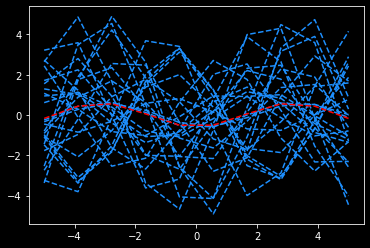

In [4]:
ts_ds = test_ds
# tr_ds, ts_ds = generate_dataset(K=10, test_size=25)
avg_pred =[]
x, _ = SinusoidGenerator(K=10).equally_spaced_samples()  
for i, sinusoid_generator in enumerate(ts_ds):
        _ , y = sinusoid_generator.equally_spaced_samples()
        plt.plot(x, y,'--', color=colors[0])
        avg_pred.append(y)
avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0),'--', color='red')
plt.show()

## Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [5]:
from model import SineModel

# Train

Step 0: loss = 1.2761316052849971, Time to run 1000 steps = 1.48 seconds
Step 1000: loss = 4.116943610666761, Time to run 1000 steps = 10.27 seconds
Step 2000: loss = 4.159831321182414, Time to run 1000 steps = 9.31 seconds
Step 3000: loss = 4.166808409670648, Time to run 1000 steps = 9.70 seconds
Step 4000: loss = 4.164864761261266, Time to run 1000 steps = 9.58 seconds
Step 5000: loss = 4.177642467568341, Time to run 1000 steps = 9.14 seconds
Step 6000: loss = 4.195790358235961, Time to run 1000 steps = 9.11 seconds
Step 7000: loss = 4.192253431402564, Time to run 1000 steps = 9.12 seconds
Step 8000: loss = 4.20712375167014, Time to run 1000 steps = 9.40 seconds
Step 9000: loss = 4.212326421165114, Time to run 1000 steps = 9.09 seconds
Step 10000: loss = 4.2146292775749705, Time to run 1000 steps = 9.14 seconds
Step 11000: loss = 4.226104786564555, Time to run 1000 steps = 9.14 seconds
Step 12000: loss = 4.233643918547362, Time to run 1000 steps = 10.10 seconds
Step 13000: loss = 4.2

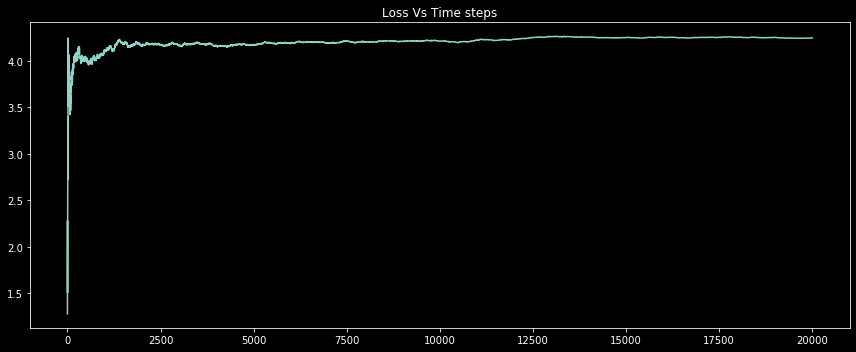

In [6]:
sine_model = SineModel()
neural_net, loss_net, inner_loop_loss_net = train.train_model(sine_model, train_ds)

In [12]:
inner_loop_loss_net

.Tensor: id=69787, shape=(), dtype=float64, numpy=3.8979173684726005>,
 <tf.Tensor: id=69882, shape=(), dtype=float64, numpy=8.93434862723021>,
 <tf.Tensor: id=69977, shape=(), dtype=float64, numpy=0.900472870908772>,
 <tf.Tensor: id=70072, shape=(), dtype=float64, numpy=1.172320272218934>,
 <tf.Tensor: id=70167, shape=(), dtype=float64, numpy=1.705573185079135>,
 <tf.Tensor: id=70262, shape=(), dtype=float64, numpy=9.229732679752777>,
 <tf.Tensor: id=70357, shape=(), dtype=float64, numpy=5.765407812433868>,
 <tf.Tensor: id=70452, shape=(), dtype=float64, numpy=11.125475072488317>,
 <tf.Tensor: id=70547, shape=(), dtype=float64, numpy=5.1243774965565905>,
 <tf.Tensor: id=70642, shape=(), dtype=float64, numpy=10.800972373869095>,
 <tf.Tensor: id=70737, shape=(), dtype=float64, numpy=3.1182685222865882>,
 <tf.Tensor: id=70832, shape=(), dtype=float64, numpy=10.943573665026701>,
 <tf.Tensor: id=70927, shape=(), dtype=float64, numpy=3.2063155768616185>,
 <tf.Tensor: id=71022, shape=(), dty

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

In [ ]:
sine_model = SineModel()
maml, loss_maml, inner_loop_loss_maml, maml_loop_loss_maml = train_maml.train_maml(sine_model, 1, train_ds)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

# Load Model

In [7]:

sinusoid_generator = SinusoidGenerator(K=10)
x, _ = sinusoid_generator.batch()
neural_net = load_model_weight(SineModel(), path="./net/neural_net_model", x=x)
maml = load_model_weight(SineModel(), path="./maml/maml_model", x=x)

print(neural_net.out.get_weights()[0].shape)
print(maml.out.get_weights()[0].shape)

(40, 1)
(40, 1)


# MAML vs Regular Neural Network

MAML


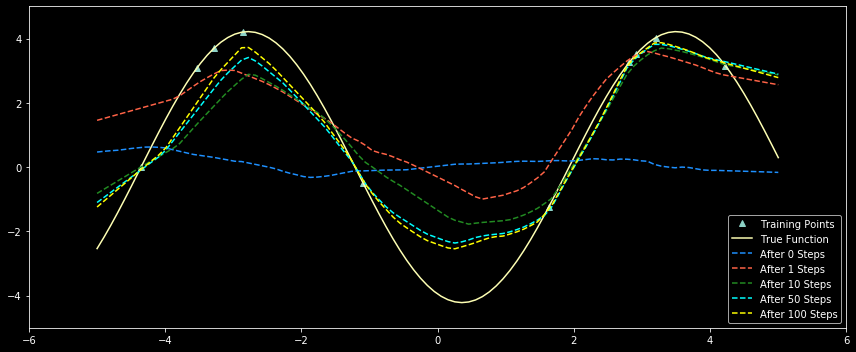

Neural Net


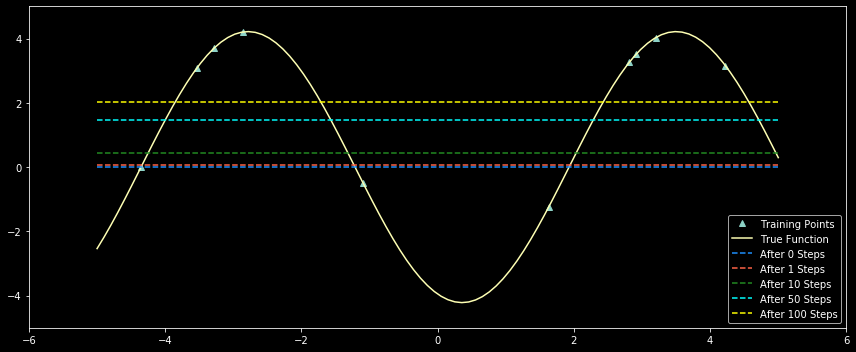

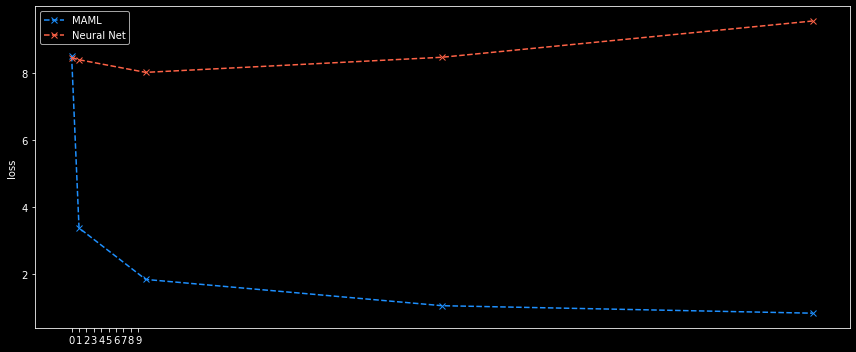

In [150]:
for _ in range(1):
    index = np.random.choice(range(len(test_ds)))
    w3_maml_model, w3_net_model, weight_gradient_net, weight_gradient_maml, loss_net, loss_maml\
                 = compare_maml_and_neural_net(maml, neural_net, test_ds[index])

In [152]:
sep = '='*30
out_grad_net = []
for key, grads in weight_gradient_net.items():
    print(f'\nkey: {key}\n\n hidden1(1,40)\n{grads[0]}\n{sep}\n hidden2(40,40)\n{grads[2]}\n{sep}\n out(40,1)\n{grads[4]}\n{sep}\n ')
    print('*='*40)
    out_grad_net.append(grads[4])



key: step1

 hidden1(1,40)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 hidden2(40,40)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 out(40,1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
 
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

key: step10

 hidden1(1,40)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 hidden2(40,40)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 out(40,1)
[

In [153]:
out_grad_net

[<tf.Tensor: id=33218, shape=(40, 1), dtype=float64, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])>,
 <tf.Tensor: id=33934, shape=(40, 1), dtype=float64, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

In [154]:
sep = '='*30
out_grad_maml = []
for key, grads in weight_gradient_maml.items():
    print(f'\nkey: {key}\n\n hidden1(1,40)\n{grads[0]}\n{sep}\n hidden2(40,40)\n{grads[2]}\n{sep}\n out(40,1)\n{grads[4]}\n{sep}\n ')
    print('*='*40)
    out_grad_maml.append(grads[4])


key: step1

 hidden1(1,40)
[[  0.87573248   1.90202095   3.68975451   1.80434255  -1.92554778
    1.95643436  -1.43082816   2.26023531   0.90459143   1.75721148
   -0.58434719   0.43794765   3.57928858  -0.72313538  -0.88782892
    0.11342253  -1.16330961 -24.53282695   2.55271644  -3.58791701
    0.         -27.04394805  -0.12740861   0.36863265   5.50597778
   -0.32928131   1.96474783   3.06817001  16.82389572  -0.18261258
    7.52261147   0.           2.22317919   0.6290464   -1.45310014
   23.46558434   1.78015586  -0.33533396   0.88251514   0.13577817]]
 hidden2(40,40)
[[-0.59317621  0.35427379  0.         ...  0.          0.8044583
  -0.25168615]
 [ 0.          0.          0.10447635 ...  0.1722833   0.
  -0.06739141]
 [-0.3493174   0.2086294   0.         ...  0.          0.47071193
  -0.14671734]
 ...
 [ 0.          0.          0.         ...  0.          0.0217075
  -0.01074536]
 [ 0.          0.          0.24335171 ...  0.40129116  0.
  -0.10502146]
 [ 0.          0.         


bin:
 [-2.28336209 -2.0419553  -1.80054851 -1.55914171 -1.31773492 -1.07632813
 -0.83492134 -0.59351454 -0.35210775 -0.11070096  0.13070583]

 bin with most amount -0.11070095825392157

bin:
 [0.         0.14234649 0.28469298 0.42703947 0.56938597 0.71173246
 0.85407895 0.99642544 1.13877193 1.28111842 1.42346491]

 bin with most amount 0.2846929828165111

bin:
 [0.         0.08479513 0.16959026 0.2543854  0.33918053 0.42397566
 0.50877079 0.59356592 0.67836106 0.76315619 0.84795132]

 bin with most amount 0.08479513213859916

bin:
 [0.         0.06471198 0.12942397 0.19413595 0.25884793 0.32355991
 0.3882719  0.45298388 0.51769586 0.58240784 0.64711983]

 bin with most amount 0.06471198266862326


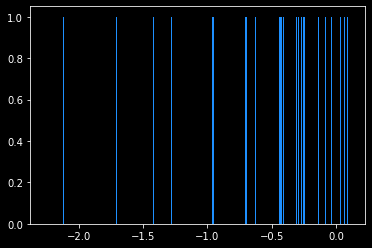

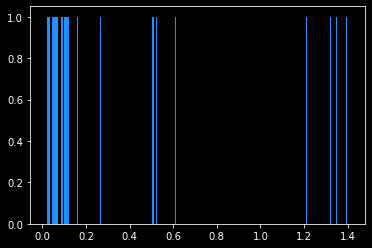

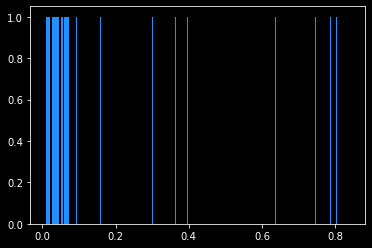

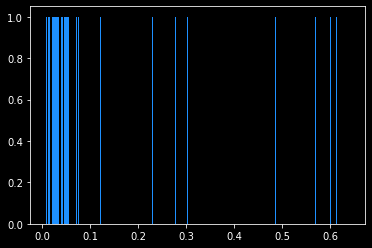

In [155]:

for i, grad in enumerate(out_grad_maml):
    fig = plt.figure(i)
    data = plt.hist(grad, facecolor='dodgerblue')
    # plt.xticks(np.linspace(-0.3,0.3,5))
    # plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    # print('n:\n', n,'\nbin:\n', bin_)
    print('\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

In [148]:
for key, loss in loss_net.items():
    print(f'\nkey: {key}\n {loss.numpy()}')


key: step1
 9.178411755851759

key: step10
 7.539646713624046


In [147]:
for key, loss in loss_maml.items():
    print(f'\nkey: {key}\n {loss.numpy()}')



key: step1
 8.435732454316147

key: step10
 1.044510360462716


# old

![alt text](https://miro.medium.com/max/585/1*WmG_R90SyXjWwu6qPfwtQQ.png)